In [1]:
import numpy as np
import pandas as pd
import time

import sys
import os

from QTL_calling import *

from matplotlib import pyplot as plt
from scipy.stats import binom_test 
import seaborn as sns
sns.set(font_scale= 1.5)
sns.set_style('whitegrid') 


import sys
sys.path.append('/work-zfs/abattle4/heyuan/old_work_files/yuan/tools/python_lib/lib/python2.7/site-packages')

from matplotlib_venn import venn3, venn2


In [2]:
def read_in_WGS_GT(samples_peaks, chromsome, window):

    WGS_fn = '%s/1k_genome_chr%d.genotypes.tsv' % (WGS_dir, chromsome)
    WGS_result = pd.read_csv(WGS_fn, comment = '$', sep='\t')
    WGS_result = WGS_result.drop_duplicates()
    
    samples = [x for x in WGS_result.columns if x.startswith('HG')]
    WGS_result.index = WGS_result[['#CHROM', 'POS']].apply(lambda x: '_'.join((str(x[0]), str(x[1]))), axis=1)
    
    # use only the SNPs from called genotypes
    QTL_by_called_genotypes = pd.read_csv('%s/CHR%d_acQTLs_WINDOW_%dkb.txt' % (QTL_dir, chromsome, window/1000), sep='\t')    
    WGS_result = WGS_result.loc[QTL_by_called_genotypes['CHR_POS']]
    
    WGS_result = WGS_result.drop_duplicates()
    WGS_result.columns = ['CHR', 'POS'] + list(WGS_result.columns[2:])
    WGS_result.index.name = 'CHR_POS'
    WGS_result = WGS_result.reset_index()
    
    samples = list(np.intersect1d(samples_peaks, WGS_result.columns))
    WGS_result = WGS_result[list(WGS_result.columns[:3]) + samples]
    
    return [WGS_result, samples]


In [3]:
def derive_QTLs_using_real_GT(chromsome, window):
    
    [PEAK_DAT, samples_peaks] = read_in_peaks(PEAK_DIR, chromsome)
    [WGS_dat, SAMPLES] = read_in_WGS_GT(samples_peaks, chromsome, window)
    WGS_DAT = obtain_numerical_gt(WGS_dat, SAMPLES)
    WEIGHT_DAT = WGS_DAT.copy()
    WEIGHT_DAT[SAMPLES] = 1
    
    compute_QTLs(chromsome, window, PEAK_DAT, WGS_DAT, WEIGHT_DAT, QTL_dir=QTL_dir, saveSuffix='_realGT')
    

In [4]:
def readin_both_results(CHROMOSOME, WINDOW):
    real_QTL = pd.read_csv('%s/CHR%d_acQTLs_WINDOW_%dkb%s.txt' % (QTL_dir, CHROMOSOME, WINDOW/1000, '_realGT'), sep='\t')
    call_QTL = pd.read_csv('%s/CHR%d_acQTLs_WINDOW_%dkb%s.txt' % (QTL_dir, CHROMOSOME, WINDOW/1000, ''), sep='\t')

    real_QTL.columns = ['CHR_POS', 'pvalue_real', 'PeakID']
    call_QTL.columns = ['CHR_POS', 'pvalue_called', 'PeakID']

    QTLs_in_both = real_QTL.merge(call_QTL, on = ['CHR_POS', 'PeakID'])
    
    return QTLs_in_both



In [5]:
if 1:
    WINDOW = 0
    WGS_dir = '/work-zfs/abattle4/heyuan/Variant_calling/datasets/GBR/Genotype'
    PEAK_DIR = '/work-zfs/abattle4/heyuan/Variant_calling/datasets/GBR/ATAC_seq/alignment_bowtie/Peaks'
    QTL_dir = '/work-zfs/abattle4/heyuan/Variant_calling/datasets/GBR/ATAC_seq/alignment_bowtie/QTLs'
    Genotype_dir = '/work-zfs/abattle4/heyuan/Variant_calling/datasets/GBR/ATAC_seq/alignment_bowtie/Called_GT/'
    VCF_dir = '/work-zfs/abattle4/heyuan/Variant_calling/datasets/GBR/ATAC_seq/alignment_bowtie/VCF_files'



In [6]:
QTLs_DAT = pd.DataFrame()
for CHROMOSOME in range(1, 23):
    token = readin_both_results(CHROMOSOME, 0)
    QTLs_DAT = QTLs_DAT.append(token)

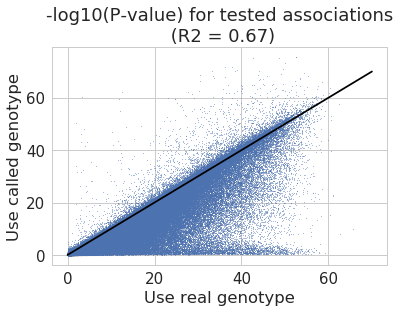

In [7]:
from sklearn.metrics import r2_score
R2 = r2_score(-np.log10(QTLs_DAT['pvalue_real']), -np.log10(QTLs_DAT['pvalue_called']))

plt.figure()
plt.scatter(-np.log10(QTLs_DAT['pvalue_real']), 
            -np.log10(QTLs_DAT['pvalue_called']), 
            s = 0.5, alpha=0.5)
plt.xlabel('Use real genotype')
plt.ylabel('Use called genotype')
plt.plot([0,70], [0,70], color='black')
plt.title('-log10(P-value) for tested associations\n (R2 = %.2f)' % R2)
plt.show()
plt.close()


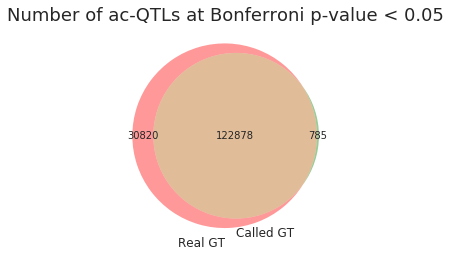

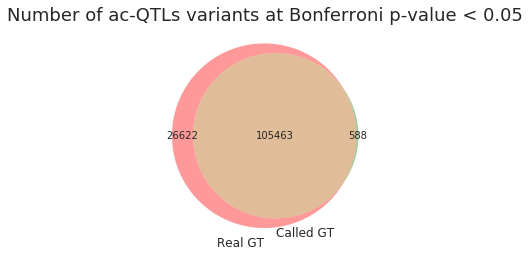

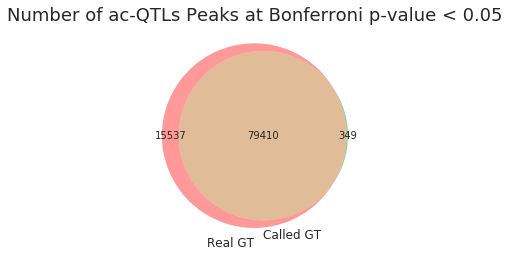

In [8]:
QTLs_real = np.where(QTLs_DAT['pvalue_real'] < 0.05 / len(QTLs_DAT))[0]
QTLs_called = np.where(QTLs_DAT['pvalue_called'] < 0.05 / len(QTLs_DAT))[0]


plt.figure()
venn2([set(QTLs_real), set(QTLs_called)], ('Real GT', 'Called GT'))
plt.title('Number of ac-QTLs at Bonferroni p-value < 0.05')
plt.show()
plt.close()

plt.figure()
venn2([set(np.array(QTLs_DAT.iloc[QTLs_real]['CHR_POS'])), 
       set(np.array(QTLs_DAT.iloc[QTLs_called]['CHR_POS']))], ('Real GT', 'Called GT'))
plt.title('Number of ac-QTLs variants at Bonferroni p-value < 0.05')
plt.show()
plt.close()



plt.figure()
venn2([set(np.array(QTLs_DAT.iloc[QTLs_real]['PeakID'])), 
       set(np.array(QTLs_DAT.iloc[QTLs_called]['PeakID']))], ('Real GT', 'Called GT'))
plt.title('Number of ac-QTLs Peaks at Bonferroni p-value < 0.05')
plt.show()
plt.close()


In [10]:
extra_in_called = QTLs_DAT.iloc[np.array(list(set(QTLs_called) - set(QTLs_real)))]
extra_in_called = extra_in_called.sort_values('pvalue_called').reset_index(drop=True)
extra_in_called = extra_in_called[extra_in_called['pvalue_real'] / extra_in_called['pvalue_called']  > 1e5]

In [11]:
EXAMINE_DAT_weight = pd.DataFrame()
EXAMINE_DAT_gt = pd.DataFrame()

for CHROMOSOME in range(1, 23):
    print('chromosome%d' % CHROMOSOME)
    [PEAK_DAT, samples_peaks] = read_in_peaks(PEAK_DIR, CHROMOSOME)
    [WGS_dat, SAMPLES] = read_in_WGS_GT(samples_peaks, CHROMOSOME, WINDOW)
    
    GT_DAT = readin_genotype(Genotype_dir = Genotype_dir, chromosome=CHROMOSOME, samples=SAMPLES)
    GT_DAT = GT_DAT.set_index('CHR_POS')
    EXAMINE_dat_gt = GT_DAT.loc[np.intersect1d(GT_DAT.index, extra_in_called['CHR_POS'])]
    EXAMINE_DAT_gt = EXAMINE_DAT_gt.append(EXAMINE_dat_gt)

    WEIGHT_DAT = readin_genotype_info(gt_dat=WGS_dat, VCF_dir = VCF_dir, chromosome=CHROMOSOME, samples=SAMPLES)
    WEIGHT_DAT = WEIGHT_DAT.set_index('CHR_POS')
    examine_dat_weight = c.loc[np.intersect1d(WEIGHT_DAT.index, extra_in_called['CHR_POS'])]
    EXAMINE_DAT_weight = EXAMINE_DAT_weight.append(examine_dat_weight)
    
    
    

chromosome1
Convert genotype to numerical values
In total 263521 variants are called
    Used 32.742532 s
Derive posterior probability for the genotypes
    Used 14.816207 seconds
chromosome2
Convert genotype to numerical values
In total 319790 variants are called
    Used 41.769267 s
Derive posterior probability for the genotypes
    Used 15.915789 seconds
chromosome3
Convert genotype to numerical values
In total 276968 variants are called
    Used 36.118296 s
Derive posterior probability for the genotypes
    Used 13.669873 seconds
chromosome4
Convert genotype to numerical values
In total 297214 variants are called
    Used 39.229781 s
Derive posterior probability for the genotypes
    Used 12.277828 seconds
chromosome5
Convert genotype to numerical values
In total 252145 variants are called
    Used 32.719985 s
Derive posterior probability for the genotypes
    Used 11.590144 seconds
chromosome6
Convert genotype to numerical values
In total 257700 variants are called
    Used 34.511

In [52]:
from scipy.stats import ranksums

number_unknown_gt = [np.sum(x==0) for x in np.array(EXAMINE_DAT_weight[SAMPLES])]
average_unknown_gt = [np.sum(x==0) for x in np.array(WEIGHT_DAT[SAMPLES])]

ranksums(number_unknown_gt, average_unknown_gt)

## Conclusion:
## No significant difference between number of variants with un-called genotypes

RanksumsResult(statistic=0.3078611662279646, pvalue=0.758187976381618)

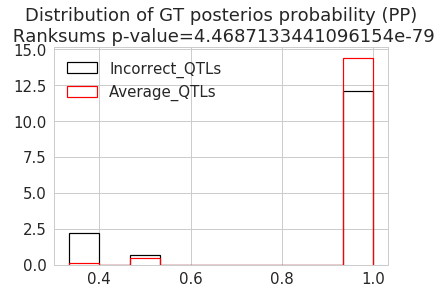

In [56]:
## Check among the variants with called genotypes

from scipy.stats import ranksums

other_dat = WEIGHT_DAT.loc[np.array(list(set(WEIGHT_DAT.index) - set(EXAMINE_DAT_weight.index)))]

number_uncertain_gt = [x[x>0] for x in np.array(EXAMINE_DAT_weight[SAMPLES])]
average_uncertain_gt = [x[x>0] for x in np.array(other_dat[SAMPLES])]
number_uncertain_gt = [a for b in number_uncertain_gt for a in b]
average_uncertain_gt = [a for b in average_uncertain_gt for a in b]

pval = ranksums(number_uncertain_gt, average_uncertain_gt)[1]

plt.figure()
plt.hist(number_uncertain_gt, 
         histtype='step', 
         density=True, 
         color='black',
        label = 'Incorrect_QTLs', linewidth=1.2)
plt.hist(average_uncertain_gt, 
         histtype='step', 
         density=True, 
         color='red',
        label = 'Average_QTLs', linewidth=1.2)
plt.legend(loc=2)
plt.title('Distribution of GT posterios probability (PP)\n Ranksums p-value=%s' % pval)
plt.show()
plt.close()

## Conclusion:
## Variants with low certainty in the called genotypes are enriched for incorrect ac-QTLs 

## --> disregard variants with PP < 0.5